# Preprocessing

In [1]:
import os
import io
import cv2
from PIL import Image
import h5py
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import tensorflow as tf

2024-09-06 14:24:03.960796: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-06 14:24:03.964987: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-06 14:24:03.976061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 14:24:03.996727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 14:24:04.004544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 14:24:04.020350: I tensorflow/core/platform/cpu_feature_gu

In [2]:
projectDir = os.getcwd() + "/"
parentDir = os.path.abspath(os.path.join(projectDir, os.pardir)) + "/"
dataPath = os.path.abspath(os.path.join(projectDir, os.pardir)) + "/isic-2024-challenge/"

metaPath = dataPath + "train-metadata.csv"
train_metadata = pd.read_csv(metaPath, sep=",")

print("Data path:", dataPath)
print("Metadata path:", dataPath)

/tmp/ipykernel_107065/3922719211.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv(metaPath, sep=",")


Data path: /home/awieber/Projects/isic-2024-challenge/
Metadata path: /home/awieber/Projects/isic-2024-challenge/


In [3]:
#normal, hairs1, hairs2, wrinkles1, wrinkles2, protrusions
trial_image_files = ["ISIC_0015670", "ISIC_0052213", "ISIC_0075726", "ISIC_0076172", "ISIC_8570031", "ISIC_5071401"]

#Filename and image id
file = dataPath + "train-image.hdf5"
#isic_id = "ISIC_0015670"

#Import hdf5 file and one image
trial_images = []
f = h5py.File(file, mode="r")
for isic_id in trial_image_files:
    image = np.array(
        Image.open(
            io.BytesIO(f[isic_id][()])
            )
        )
    trial_images.append(image)
    print("Height:", len(image), "Width:", len(image[0]))

Height: 139 Width: 139
Height: 125 Width: 125
Height: 165 Width: 165
Height: 135 Width: 135
Height: 125 Width: 125
Height: 119 Width: 119


In [4]:
#Function to show image
def show_img(image):
    plt.imshow(image, interpolation=None)
    plt.grid(None)
    plt.show()

In [5]:
#Image cropping
def crop_image(image_list, nbPix = 100):
    output_images = []
    for image in image_list:
        #Height adjustments
        h = len(image)
        adj = len(image) - nbPix
        h1 = round(adj / 2) #Top
        h2 = h - (adj - h1) #Bottom

        #Width adjustments
        w = len(image[0])
        w_adj = w - nbPix
        w1 = round(w_adj / 2) #Left
        w2 = w - (w_adj - w1) #Right

        img = image[h1:h2,w1:w2]
        output_images.append(img)
        
    return np.array(output_images)

In [6]:
imgs = crop_image(trial_images, nbPix=100)
print("Shape of array:", imgs.shape)
print("Shape of image:", imgs[0].shape)

Shape of array: (6, 100, 100, 3)
Shape of image: (100, 100, 3)


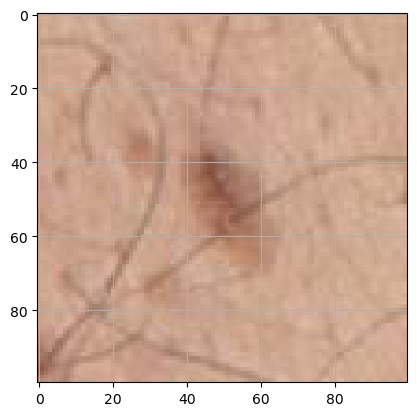

In [7]:
show_img(imgs[1])

In [29]:
#Code taken from https://www.kaggle.com/code/sanjitschouhan/visualizing-conv2d-output

#Edge filters
filter_kernel_1 = [[1, 1, 1, 1],
                [1, 1, 1, 1],
                [-1, -1, -1, -1],
                [-1, -1, -1, -1]]

filter_kernel_2 = [[-1, -1, -1, -1],
                [-1, -1, -1, -1],
                [1, 1, 1, 1],
                [1, 1, 1, 1]]

filter_kernel_3 = [[1, 1, -1, -1],
                [1, 1, -1, -1],
                [1, 1, -1, -1],
                [1, 1, -1, -1]]

filter_kernel_4 = [[-1, -1, 1, 1],
                [-1, -1, 1, 1],
                [-1, -1, 1, 1],
                [-1, -1, 1, 1]]

filter_kernel_5 = [[0, -1, 0],
                [-1, 4, -1],
                [0, -1, 0]]

filter_kernel_6 = [[-1, -1, -1],
                [0, 0, 0],
                [1, 1, 1]]

filter_kernel_7 = [[-1, 0, 1],
                [-1, 0, 1],
                [-1, 0, 1]]

filter_list_edges = [filter_kernel_1, filter_kernel_2, filter_kernel_3, filter_kernel_4, filter_kernel_5, filter_kernel_6, filter_kernel_7]



In [32]:
#Code taken from https://www.kaggle.com/code/sanjitschouhan/visualizing-conv2d-output

#Plot of each filter and its effect
def filter_plots(gray_image, filter_list):
    plt.figure(figsize=(20,10))
    for i,filter_kernel in enumerate(filter_list):
        x = tf.constant(np.reshape(gray_image,(1,100,100,1)), dtype=tf.float32)
        filter_kernel = np.array(filter_kernel)
        kernel = np.reshape(filter_kernel, (*filter_kernel.shape,1,1))
        kernel = tf.constant(kernel, dtype=tf.float32)
        x_out = tf.nn.conv2d(x, kernel, strides=[1, 1, 1, 1], padding='SAME')

        image_filtered = np.reshape(x_out, (100,100))
        
        plt.subplot(3,6, 2*i+1)
        plt.imshow(filter_kernel, cmap='gray')
        plt.title("Filter Kernel "+str(i+1))
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(3,6, 2*i+2)
        plt.imshow(np.reshape(image_filtered, (100,100)), cmap='gray')
        plt.title("Kernel Output "+str(i+1))
        plt.xticks([])
        plt.yticks([])
    return x_out                                                                      

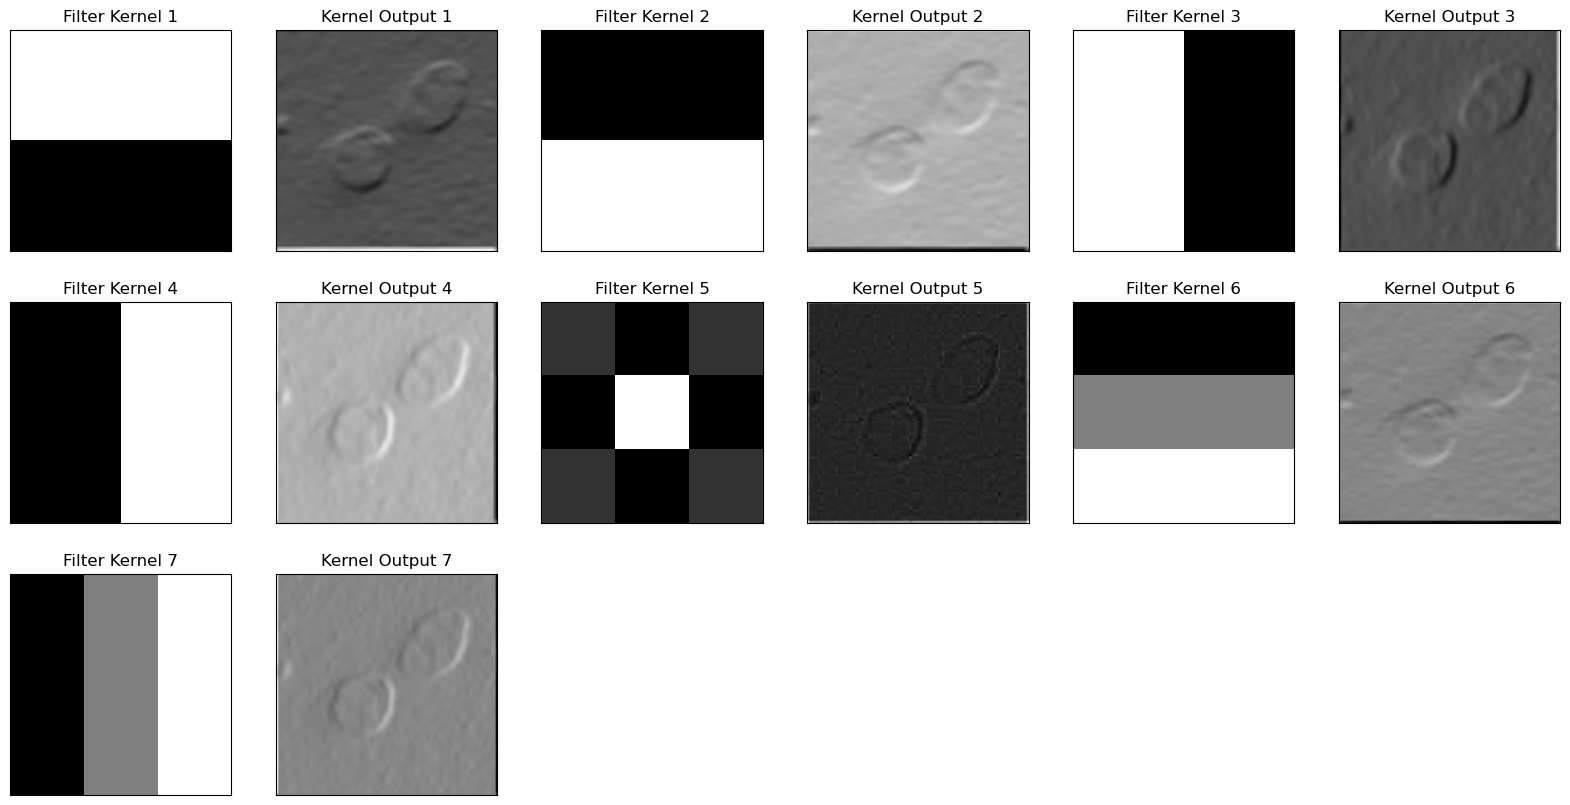

In [35]:
#Grayscale image to use
gray_image = cv2.cvtColor(imgs[5], cv2.COLOR_RGB2GRAY)
conv2D_img = filter_plots(gray_image, filter_list_edges)


Tensor Shape:  (1, 100, 100, 1)
Image Set Shape:  (100, 100, 1)


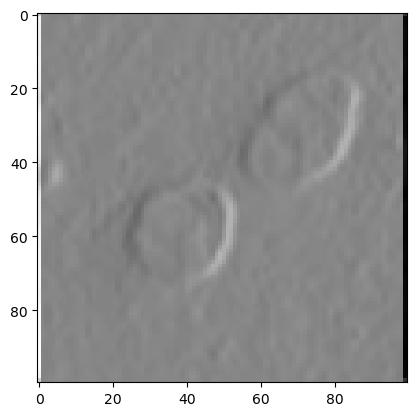

In [46]:
#The tensor object manipulated to give an image
print("Tensor Shape: ", conv2D_img.shape)
print("Image Set Shape: ", conv2D_img[0].shape)

plt.imshow(conv2D_img[0][:,:,0], cmap='gray')

3
Shape of tensor object: (1, 11, 11, 3)


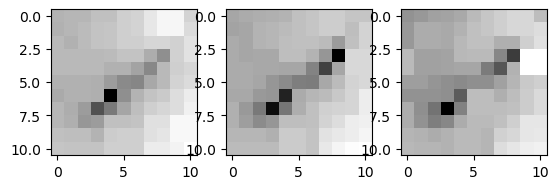

In [114]:
#Pooling - visualization of result
rgb_img = imgs[5]
gray_image = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
#Gray tensor
x1 = tf.constant(np.reshape(gray_image,(1,100,100,1)), dtype=tf.float32)
#RGB tensor
x2 = tf.constant(np.reshape(rgb_img,(1,100,100,3)), dtype=tf.float32)

x=x2
nb_levels = x.shape[-1]
print(nb_levels)

val = 16
pool_size=(val,val)
strides= val//2
max_pool_2D = tf.keras.layers.MaxPool2D(pool_size=pool_size, strides=strides)
pooled_image = max_pool_2D(x)
print("Shape of tensor object:", pooled_image.shape)


for level in range(0, nb_levels):
    plt.subplot(1, 3, level+1)
    plt.imshow(pooled_image[0][:,:,level], cmap='gray')

In [ ]:
#Conv2D(nb_filters, size_filter_kernel, activation_fnct, padding, input_shape(height, width, colors))
#Dense: neural network, dense links
#Softmax: multiclass?
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 5, activation='relu', padding='same', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, 5, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, 5, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(256, 5, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
    ])
model.summary()

/home/awieber/miniconda3/envs/ISIC24_skin_cancer/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 100, 100, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 19, 19, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 5, 5, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,341,765 (5.12 MB)

 Trainable params: 1,341,765 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

## Tensorflow preparations

In [78]:
def init_weights(shape):
    init_random_dist = tf.random.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x,W):
    return tf.nn.conv2d(x,W, strides=[1,1,1,1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    #return tf.nn.max_pool(x, ksize=[1,1,1,1], strides=[1,1,1,1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

In [48]:
convo_1 = convolutional_layer(imgs, shape=[4,4,3,100])
convo_1_pooling = max_pool_2by2(convo_1)

In [ ]:
x1 = convo_1_pooling.numpy()
x1[1].shape

(100, 100, 100)

(100, 100, 100)


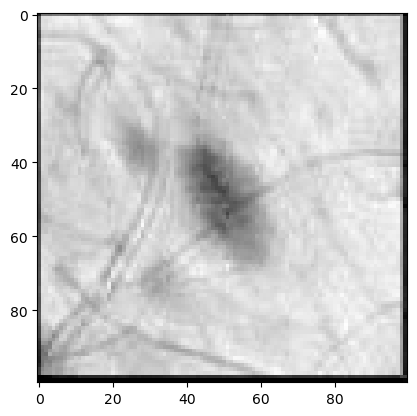

In [77]:
print(convo_1[5].shape)
plt.imshow(convo_1[1][:,:,99], cmap='gray')

In [ ]:
#Cast as a tensorflow float32
def normalize_img(image):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255.

In [ ]:
norm_img = normalize_img(cropped_trial_images[2])
type(norm_img)

tensorflow.python.framework.ops.EagerTensor

TypeError: Invalid shape (100, 100, 100) for image data

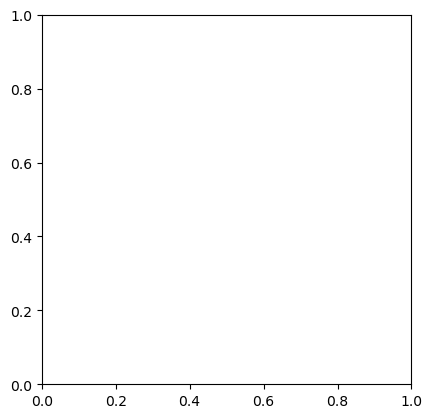